# Fashion Image Classification Using KNN
In this notebook, we train a machine learning model using K-Nearest Neighbors (KNN) to classify fashion images into five categories: casual, formal, streetwear, sporty, and vintage. The dataset consists of images scraped from Reddit and manually labeled using Label Studio.

The workflow includes the following steps:

- Feature extraction using the pre-trained MobileNetV2 model.

- Dimensionality reduction using PCA to simplify the feature space.

- Hyperparameter tuning with GridSearchCV, using 5-fold cross-validation (cv=5) to find the optimal settings.

- Standardization of features using StandardScaler.

Finally, we evaluated the model's performance using accuracy and F1 score, providing insight into both overall and per-class classification effectiveness.

## Required Libraries
n this section, we import all the necessary libraries used throughout the project. These include tools for data handling, image processing, machine learning, and model evaluation.

In [28]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Reading the Data
Label Studio provided two outputs after annotation:

- A folder containing the labeled **images**, each renamed according to Label Studio's internal naming convention.

- A **CSV** file containing the assigned labels, corresponding image file names, and additional metadata (e.g., annotation IDs, timestamps).

We use this CSV file to link each image with its respective label and prepare the data for training.

In [2]:
label_file = pd.read_csv('Dataset/labels_file.csv')
label_file_clean = label_file.dropna(subset=['choice']) #dropping the images with no labels

labels = label_file_clean[['choice']]
image_paths = label_file_clean['image'].apply(os.path.basename).tolist()

In [3]:
print(f"Number of Images: {len(image_paths)}")
print(f"Number of Labels: {len(labels)}")

Number of Images: 582
Number of Labels: 582


In [4]:
label_file.head()

,annotation_id,annotator,choice,created_at,id,image,lead_time,updated_at
0,1,1,streetwear,2025-07-13T14:06:47.817786Z,1,/data/upload/2/8c0dddfa-streetwear_706.jpg,6.106,2025-07-13T14:24:14.261162Z
1,2,1,streetwear,2025-07-13T14:06:52.413641Z,2,/data/upload/2/9c61426e-streetwear_705.jpg,17.992,2025-07-13T14:24:19.881258Z
2,3,1,casual,2025-07-13T14:07:02.105802Z,3,/data/upload/2/e4442caf-streetwear_701.jpg,2.541,2025-07-13T14:07:02.105841Z
3,4,1,casual,2025-07-13T14:07:06.161496Z,4,/data/upload/2/0096a173-streetwear_699.jpg,3.060,2025-07-13T14:07:06.161533Z
4,5,1,vintage,2025-07-13T14:07:10.580991Z,5,/data/upload/2/109daa13-streetwear_698.jpg,13.651,2025-07-13T14:24:39.311053Z


## Some Sample Image Visualization
To better understand the dataset, we visualized a few randomly selected fashion images along with their corresponding style labels. This step provides a quick sanity check to verify that:

Images have been correctly loaded and preprocessed.

Labels align with the visual content.

The dataset includes visual variety across the defined style categories (casual, streetwear, formal, sporty, vintage).

Visualizing samples early in the pipeline is helpful for spotting potential issues such as mislabeled data, corrupted images, or class imbalance — all of which can affect model performance later.


Attempting to display random images...
Processing: Images/72e679fe-fashion_8.jpg
Processing: Images/6a50402c-streetwear_109.jpg
Processing: Images/b540d7c0-streetwear_502.jpg
Processing: Images/365d0727-fashion_163.jpg
Processing: Images/b646e218-fashion_179.jpg


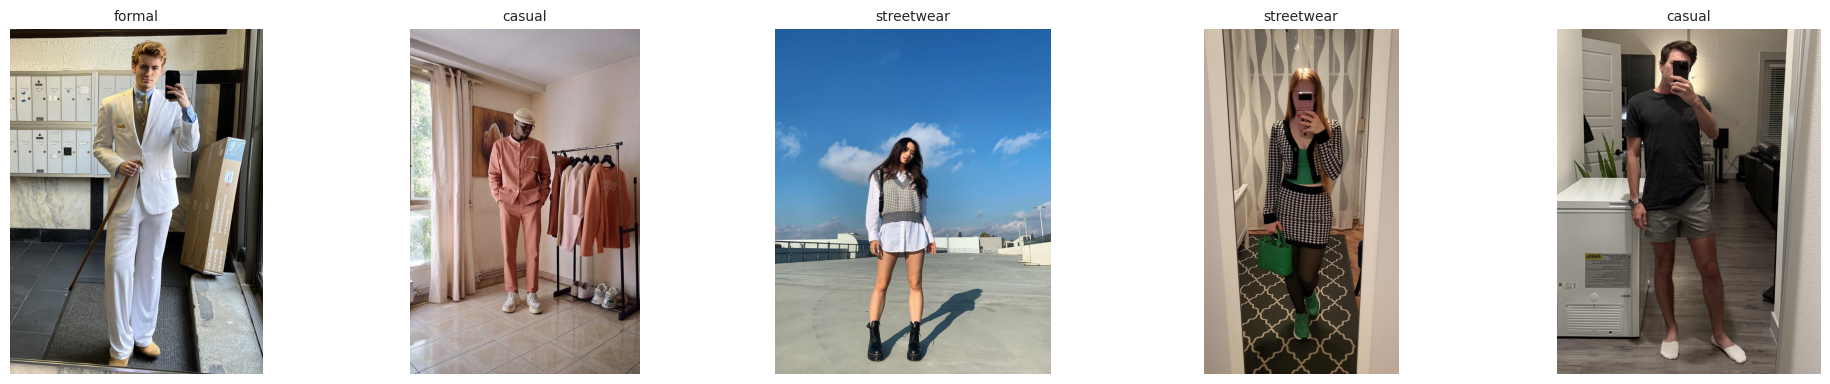

In [24]:
NUM_IMAGES = min(5, len(label_file_clean))

def load_for_display(path):
    """Load full-size image for display only"""
    return load_img(f'Dataset/images/{path}')

if label_file_clean.empty:
    print("No images to display after filtering missing files.")
else:
    print("Attempting to display random images...")
    fig, axes = plt.subplots(1, NUM_IMAGES, figsize=(NUM_IMAGES * 4, 4))

    # Randomly sample rows from the DataFrame
    sample_df = label_file_clean.sample(NUM_IMAGES, random_state=42)

    for ax, (_, row) in zip(axes, sample_df.iterrows()):
        img_path = os.path.basename(row['image'])
        label = row['choice']
        full_path = f'Dataset/images/{img_path}'

        print(f"Processing: {full_path}")
        if os.path.exists(full_path):
            img = load_for_display(img_path)
            ax.imshow(img)
            ax.set_title(label, fontsize=10)
            ax.axis('off')
        else:
            print(f"File not found: {img_path}")
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()

## Visualization of class Distribution
The bar chart below shows the distribution of labeled fashion images across the five defined style categories: streetwear, casual, formal, vintage, and sporty.

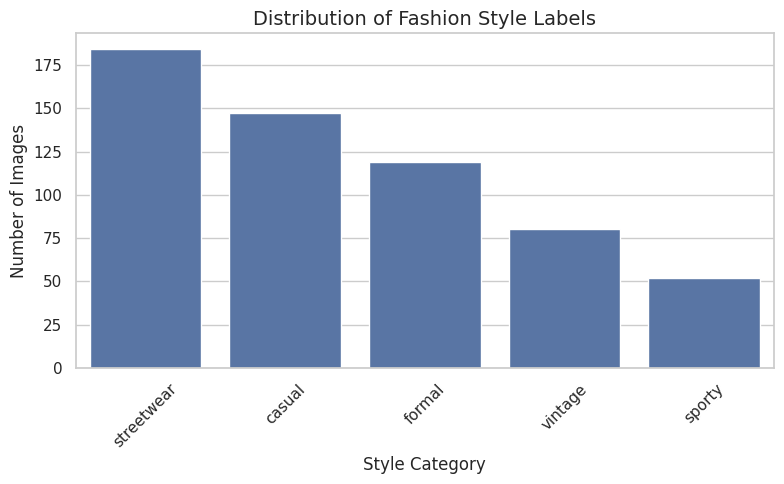

In [5]:
# Set a clean style
sns.set(style="whitegrid")

# Plot the count of each label in the 'choice' column
plt.figure(figsize=(8, 5))
sns.countplot(data=label_file_clean, x='choice', order=label_file_clean['choice'].value_counts().index)

# Add title and labels
plt.title('Distribution of Fashion Style Labels', fontsize=14)
plt.xlabel('Style Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the plot, we observe that:

- Streetwear is the most represented category, followed by casual and formal.

- Vintage and especially sporty have noticeably fewer examples, indicating class imbalance.

This imbalance can potentially affect model performance, as classes with fewer samples are harder for the model to learn. In the later stages, we will use techniques like stratified sampling to help us mitigate this issue.



## Feature Extraction Using Pre-trained MobileNetV2
To represent each fashion image numerically for classification, we use deep feature extraction with the pre-trained MobileNetV2 model from Keras. This approach leverages knowledge learned from ImageNet, allowing us to extract high-level image features without training a deep model from scratch.

In [29]:
model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

features_list = []
for img_path in image_paths:
    # Preprocess each image
    img = image.load_img(f'Dataset/images/{img_path}', target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize to [0, 1]

    # Extract features from the image
    features = model.predict(img_array)
    features_list.append(features.flatten())

X = np.array(features_list)

# Check if the final output sizes match
print("Feature matrix shape:", X.shape)
print("Labels shape:", labels.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━

## Preprocessing the Data
To evaluate our model's performance, we split the dataset into training and test sets using an 80/20 ratio. We used stratify=labels to ensure that the class distribution remains consistent in both sets. This is especially important for imbalanced datasets, as it prevents certain classes from being underrepresented in the training or test data.

By setting random_state=42, we ensure that the split is reproducible across runs.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels  # This ensures that the target labels are stratified
)

At later step, we perform scaling and PCA because:

- Scaling is essential before PCA, because PCA is sensitive to the scale of features.

- The pipeline guarantees that the steps are applied in the correct sequence every time (scaling → PCA).

In [31]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('knn', KNeighborsClassifier())
])

### Hyperparameter Tuning with GridSearchCV
To improve the performance of our KNN classifier, we performed hyperparameter tuning using GridSearchCV. This approach systematically tests multiple combinations of hyperparameters and selects the best set based on cross-validation accuracy.

In our case, we tuned the following KNN parameters:

- n_neighbors: number of neighbors (k), tested from 1 to 15.

- weights: how each neighbor contributes to the prediction — equally ('uniform') or weighted by distance ('distance').

- metric: the distance function used to measure similarity between points — either 'euclidean' or 'manhattan'.

We used 5-fold cross-validation (cv=5) to evaluate each parameter combination and selected the one that achieved the highest average validation accuracy.

By using n_jobs=-1, we parallelized the search across all CPU cores to speed up computation.

The result is a well-tuned KNN model, optimized for our dataset.

In [33]:
# Define the hyperparameter grid
param_grid = {
    'knn__n_neighbors': list(range(1, 16)),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan']
}
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)


# Best hyperparameters
print("Best parameters found:", grid.best_params_)
print("Best cross-validated accuracy:", grid.best_score_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.31612903 0.31612903 0.31182796 0.31612903 0.35483871 0.34408602
 0.35053763 0.36344086 0.3311828  0.35913978 0.32043011 0.36344086
 0.33763441 0.36129032 0.33333333 0.3483871  0.32688172 0.35268817
 0.33333333 0.35483871 0.32903226 0.34623656 0.35268817 0.37419355
 0.35698925 0.36774194 0.34193548 0.36774194 0.3655914  0.37204301
        nan 0.30107527        nan 0.30107527        nan 0.32903226
        nan 0.32688172        nan 0.31397849        nan 0.33333333
        nan 0.3311828         nan 0.3311828         nan 0.33548387
        nan 0.33333333        nan 0.32903226        nan 0.30537634
        nan 0.32258065        nan 0.30752688        nan 0.32043011]
  warnings.warn(


Best parameters found: {'knn__metric': 'euclidean', 'knn__n_neighbors': 12, 'knn__weights': 'distance'}
Best cross-validated accuracy: 0.3741935483870968


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


The best obtained hyperparameters are as follows:

In [35]:
best_knn = grid.best_estimator_
best_knn

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.95)),
                ('knn',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=12,
                                      weights='distance'))])

We train a new KNN model using the best-obtained hyperparameters and use it to predict the outputs on the test set.

In [39]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('knn', KNeighborsClassifier(
        n_neighbors=12,
        metric='euclidean',
        weights='distance'
    ))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_classification.py:239: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## Model Evaluation
After training the KNN model using the best-obtained hyperparameters (n_neighbors=12, metric='euclidean', and weights='distance'), we evaluated its performance on the test dataset. The evaluation includes overall accuracy, per-class precision, recall, and F1-score.


In [40]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.41025641025641024
Classification Report:
               precision    recall  f1-score   support

      casual       0.25      0.13      0.17        30
      formal       0.43      0.75      0.55        24
      sporty       0.00      0.00      0.00        10
  streetwear       0.50      0.65      0.56        37
     vintage       0.20      0.12      0.15        16

    accuracy                           0.41       117
   macro avg       0.28      0.33      0.29       117
weighted avg       0.34      0.41      0.36       117



- The model achieved an overall accuracy of 41%, indicating moderate performance. Here's a breakdown:

- Formal and Streetwear categories were recognized relatively well with F1-scores of 0.55 and 0.56 respectively.

- The Sporty category was poorly classified with an F1-score of 0.00, likely due to its low representation in the dataset (only 10 samples).

- The macro average F1-score was 0.29, highlighting class imbalance and difficulty in detecting underrepresented categories.

This highlights the importance of addressing class imbalance and possibly using more robust models or data augmentation techniques to improve classification performance.

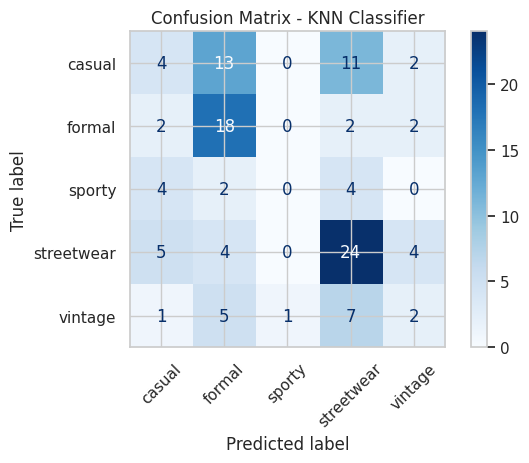

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined
labels = ['casual', 'formal', 'sporty', 'streetwear', 'vintage']
cm = confusion_matrix(y_test, y_pred, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - KNN Classifier')
plt.tight_layout()
plt.show()

According to the confusion matrix above, casual is often misclassified as:

- Formal (13 times)

- Streetwear (11 times)

- Sporty is poorly classified overall — often predicted as other categories.

- Vintage is most frequently confused with Formal and Streetwear